# Intro to Outlier/Novelty Detection 

In this lab, we'll be covering some very basic algorithms for anomaly detection.

## Getting started
First, we'll need to import a few modules to construct a regression problem and model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(0)

## Generating data and first attempts at a linear model

In this section, we create some synthetic data to experiment with linear regression and compare the differences between linear regression with and without outlier removal.

In [2]:
# Make some data for regression
X, y = make_regression(n_samples = 20, n_features = 1, noise=3.0, bias=100.0)

# Generate some significant outliers
X_outliers = np.random.normal(0, 0.5, size=(4, 1))
y_outliers = np.random.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + abs(X.mean()) * 3
X_outliers[2:, :] += X.min() - abs(X.mean()) * 3
y_outliers[:2] += y.min() - abs(y.mean()) * 2
y_outliers[2:] += y.max() + abs(y.mean()) * 2

# Add outliers to existing data
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))

It's always a good idea to visually confirm any suspicions about a particular dataset. If we plot every data point, we should see four obvious outliers given the above code:

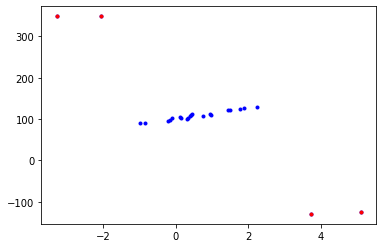

In [3]:
# Visually confirm that the data above contains four strong outliers.
plt.plot(X, y, 'b.')
plt.plot(X_outliers, y_outliers, 'r.')
plt.show()

**The outliers are the values in the corner.**
Looking good so far. The outliers are the pairs of points in the upper left and lower right corners of the plot.

#### What would you expect to be the result of fitting a linear regression model to this data?

We should attempt to fit a model to the data, first without outlier reduction:

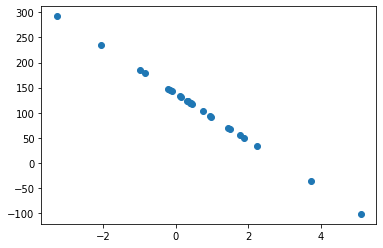

In [4]:
# Fit the model and predict without running outlier reduction
raw_model = Ridge().fit(X, y)
y_pred = raw_model.predict(X)

# plot results
plt.scatter(X, y_pred)
plt.show()

Something is obviously wrong - the high-variance outliers are causing strong *overfitting* in the model,  
producing a negative-slope model for a positive-slope trend.

## How to reduce overfitting: EllipticEnvelope

One method of outlier reduction is to fit an `EllipticEnvelope` to the data  and use its `predict()` method to detect and retain only those data points which are *inliers*.

Elliptic Envelope is most suited for Gaussian distributed datasets because it detects outliers by estimating the covariance matrix. This algorithm attempts to minimize the volume of the ellipsoid corresponding to the covariance matrix by discarding a fixed fraction of contamination points.
This is to say you would have to have a rough idea of the fraction of contamination points to be rejected in order to use this algorithm.

Now let's try this.

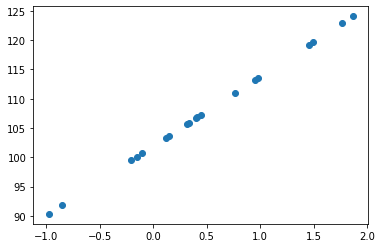

In [5]:
def elliptic_envelope_session():
    # Fit envelope
    envelope = EllipticEnvelope(support_fraction=1, contamination=0.2).fit(X)

    # Create an boolean indexing array to pick up outliers
    outliers = envelope.predict(X)==-1

    # Re-slice X,y into a cleaned dataset with outliers excluded
    X_clean = X[~outliers]
    y_clean = y[~outliers]
    return X_clean, y_clean

def fit_plot(dataset_clean):
    # Unpack cleaned dataset
    X_clean, y_clean = dataset_clean
    
    # Assuming we have our set of inliers in X_clean we can re-fit
    model = Ridge().fit(X_clean, y_clean)
    y_pred = model.predict(X_clean)
    
    # Plot the regression
    plt.scatter(X_clean, y_pred)
    plt.show()
    
fit_plot(elliptic_envelope_session())

Now we can successfully create a regression model on the cleaned dataset. 
It did a job of sequestering the outliers.

## Alternatives to the EllipticEnvelope: KMeans, LocalOutlierFactor

Ultimately, most of the statistical learning algorithms available to you in `scikit` for outlier reduction are similar in usage and function.  

Given that the goal of this exercise is to group 'good' inputs while avoiding 'bad' inputs,  and the 'bad' inputs are those with relatively high variance, we can attempt to preprocess our inputs with a round of `KMeans` clustering:

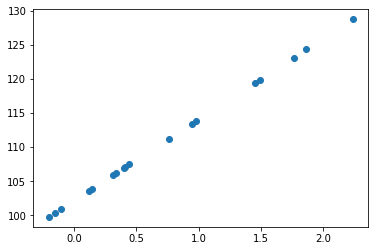

In [6]:
def kmeans_session():
    # run k-means clustering
    km_clusters = KMeans(n_clusters=3, algorithm="full").fit_predict(X, y)
    
    # create cluster distribution, this time they are in tuples so we can sort easily
    dist_clusters = ((np.sum(km_clusters==z), z) for z in np.unique(km_clusters))
    
    # sort clusters descendingly by number of data entries in cluster
    dist_clusters = sorted(dist_clusters, reverse = True)
    
    # find out the cluster with max number of data entries
    max_cluster = dist_clusters[0][1]

    # select data in max_cluster as inliers
    inliers = km_clusters == max_cluster
    
    return X[inliers], y[inliers]

fit_plot(kmeans_session())

Success! It seems we have managed to compensate for the outliers.

### Further practice: tweaking parameters
As an exercise, you could try changing to selector clusters other than `max_cluster`,  and see how the predictions change.

## Other options: LocalOutlierFactor

Though, KMeans is by no means the only way to achieve outlier reduction. There are many other valid measures of covariance which we can apply to reduce overfitting.

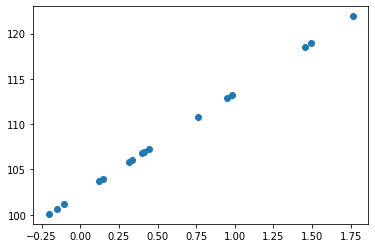

In [7]:
def local_outlier_factor_session():
    lof_labels = LocalOutlierFactor(n_neighbors=10).fit_predict(X, y)
    inliers = lof_labels == 1 # select inliers
    return X[inliers], y[inliers]

fit_plot(local_outlier_factor_session())

### Parameter tuning with LocalOutlierFactor
As an exercise, try changing `n_neighbors` in the LocalOutlierFactor constructor call. Different values will change the fit and behavior of the model - this is especially true given such a small dataset, and given that the default value for n_neighbors is 20.

# Save your notebook!